Bayesian GPLVM
--
This notebook shows how to use the Bayesian GPLVM model.

In [1]:
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
np.random.seed(42)
gpflow.settings.numerics.quadrature = 'error'  # throw error if quadrature is used for kernel expectations

### Data

We are using the "three phase oil flow" data set used initially for demonstrating the Generative Topographic mapping from *Bishop, C. M. and James, G. D. (1993): Analysis of multiphase flows using dual-energy gamma densitometry and neural networks. Nuclear Instruments and Methods in Physics Research A327, 580-593*.

In [2]:
data = np.load('data/three_phase_oil_flow.npz')
Y = data['Y']
labels = data['labels']

print('Number of points x Number of dimensions', Y.shape)

Number of points x Number of dimensions (100, 12)


### Model construction
Create Bayesian GPLVM model using additive kernel.

In [3]:
Q = 5
M = 20  # number of inducing pts
N = Y.shape[0]
X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]

fHmmm = False
if(fHmmm):
    k = (kernels.RBF(3, ARD=True, active_dims=slice(0,3)) + 
         kernels.Linear(2, ARD=False, active_dims=slice(3,5)))
else:
    k = (kernels.RBF(3, ARD=True, active_dims=[0,1,2]) + 
         kernels.Linear(2, ARD=False, active_dims=[3, 4]))
    
m = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

opt = gpflow.train.ScipyOptimizer()
m.compile()
opt.minimize(m, maxiter=gpflow.test_util.notebook_niter(10000))

lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -148.020057
  Number of iterations: 5402
  Number of functions evaluations: 5551


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -148.020057
  Number of iterations: 5402
  Number of functions evaluations: 5551


### Compute and sensitivity to input
Sensitivity is a measure of the importance of each latent dimension. 

In [4]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BayesianGPLVM/kern/kernels/0/lengthscales,Parameter,None,+ve,True,"(3,)",True,"[2.92768860478, 7.13288180325, 1.45483099534]"
BayesianGPLVM/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,0.6787500924312497
BayesianGPLVM/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.027179996202905617


In [5]:
kern = m.kern.kernels[0]
sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
print(sens)

[ 0.28140387  0.11550211  0.56629458]


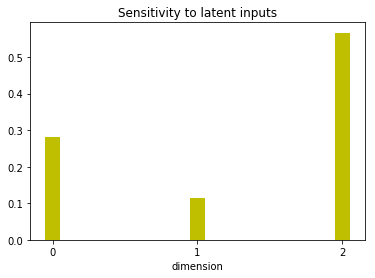

In [6]:
fig, ax = plt.subplots()
dims = np.arange(len(sens))
ax.bar(dims, sens, 0.1, color='y')
ax.set_xticks(dims)
ax.set_xlabel('dimension')
ax.set_title('Sensitivity to latent inputs');

### Plotting vs PCA
We see that using the 2 more relevant dimensions, the Bayesian GPLVM is able to seperate the
three classes while PCA cannot.

In [7]:
dim1, dim2 = sens.argsort()[::-1][:2]  # the two dimensions with highest sensitivity

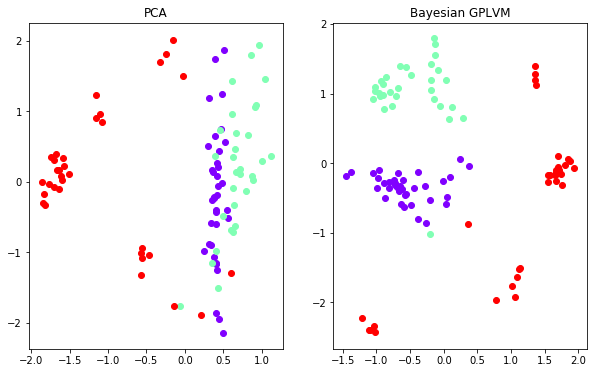

In [8]:
XPCAplot = gpflow.models.PCA_reduce(Y, 2)
GPLVM_X_mean = m.X_mean.read_value()

f, ax = plt.subplots(1,2, figsize=(10,6))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

for i, c in zip(np.unique(labels), colors):
    ax[0].scatter(XPCAplot[labels==i, 0], XPCAplot[labels==i, 1], color=c, label=i)
    ax[0].set_title('PCA')
    ax[1].scatter(GPLVM_X_mean[labels==i, dim1], GPLVM_X_mean[labels==i, dim2], color=c, label=i)
    ax[1].set_title('Bayesian GPLVM')
    